In [1]:
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np
import torch

import librosa
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import tqdm.notebook as tqdm

import json

In [2]:
from transforms import *
from torchvision.transforms import Compose

# Dataset

In [3]:
class SpeechCommandsDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.classes = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d)) and not d.startswith('_')]
        self.classes.sort()

        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}
        self.idx_to_class = {idx: c for c, idx in self.class_to_idx.items()} 
        
        self.class_indices = [[] for _ in range(len(self.classes))]
 
        data = []
        cur_idx = 0

        for data_class in self.classes:
            folder_path = os.path.join(folder, data_class)
            target = self.class_to_idx[data_class]

            for file_name in os.listdir(folder_path):
                path = os.path.join(folder_path, file_name)
                data.append((path, target))

                self.class_indices[target].append(cur_idx)
                cur_idx += 1

        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        path, target = self.data[index]
        data = {'path': path, 'target': target}

        if self.transform is not None:
            data = self.transform(data)

        return data

    def get_classes_number(self):
        return len(self.classes)

    def get_class_from_idx(self, idx):
        if idx in self.idx_to_class.keys():
            return self.idx_to_class[idx]
        return 'unknown'
    
    def get_idx_from_class(self, c):
        if c in self.class_to_idx.keys():
            return self.class_to_idx[c]
        return -1

    def get_class_indices(self):
        return self.class_indices

    def make_weights_for_balanced_classes(self):
        """adopted from https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/3"""

        classes_number = len(self.classes)
        classes_size = np.zeros(classes_number)

        for i in range(classes_number):
            classes_size[i] = len(self.class_indices[i])

        total_size = float(sum(classes_size))
        weight_per_class = total_size / classes_size

        weight = np.zeros(len(self))
        for idx, item in enumerate(self.data):
            weight[idx] = weight_per_class[item[1]]
        return weight

class BackgroundNoiseDataset(Dataset):
    """Dataset for silence / background noise."""

    def __init__(self, folder, transform=None, sample_rate=16000, sample_length=1):
        audio_files = [d for d in os.listdir(folder) if os.path.isfile(os.path.join(folder, d)) and d.endswith('.wav')]
        samples = []
        for f in audio_files:
            path = os.path.join(folder, f)
            s, sr = librosa.load(path, sr=sample_rate)
            samples.append(s)

        samples = np.hstack(samples)
        c = int(sample_rate * sample_length)
        r = len(samples) // c
        self.samples = samples[:r*c].reshape(-1, c)
        self.sample_rate = sample_rate
        self.transform = transform
        self.path = folder

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        data = {'samples': self.samples[index], 'sample_rate': self.sample_rate, 'target': 1, 'path': self.path}

        if self.transform is not None:
            data = self.transform(data)

        return data


# DataLoader + Loss

## Triplet

In [4]:
import torch.nn as nn
import torch

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = nn.functional.pairwise_distance(anchor, positive, 2)
        distance_negative = nn.functional.pairwise_distance(anchor, negative, 2)
        losses = nn.functional.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()


In [5]:

class TripletLoader(DataLoader):
    def __init__(self, dataset, batch_size=30, shuffle=True, num_workers=0):
        super().__init__(dataset=dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

        self.dataset_norm = dataset
        self.triplets_in_batch = batch_size // 3
        self.class_indices = self.dataset_norm.get_class_indices()
        self.labels = np.arange(len(self.class_indices))
        
    def __iter__(self):
        batch=[]

        for i in range((len(self.dataset_norm) + self.batch_size - 1) // self.batch_size):
            label_pairs = np.zeros((self.triplets_in_batch, 2), dtype=np.int32)

            for i in range(self.triplets_in_batch):
                anchor_label, negative_label = np.random.choice(self.labels, size=2, replace=False)
                label_pairs[i] = [anchor_label, negative_label]
            
            for anchor_label, negative_label in label_pairs:
                anchor_idx, positive_idx = np.random.choice(self.class_indices[anchor_label], 2, replace=False)
                negative_idx = np.random.choice(self.class_indices[negative_label])

                anchor, anchor_label = self.dataset_norm.__getitem__(anchor_idx)
                positive, positive_label = self.dataset_norm.__getitem__(positive_idx)
                negative, negative_label = self.dataset_norm.__getitem__(negative_idx)

                triplet = torch.stack((anchor, positive, negative))
                triplet_labels = torch.stack((anchor_label, positive_label, negative_label))

                if len(batch) == 0:
                    batch.append(triplet)
                    batch.append(triplet_labels)
                else:
                    batch[0] = torch.vstack((batch[0], triplet))
                    batch[1] = torch.hstack((batch[1], triplet_labels))
            
            yield batch
            batch = []

## N_pair

## Lifted Structured Loss

In [6]:
class LiftedStructuredLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(LiftedStructuredLoss, self).__init__()
        self.margin = margin

    def forward(self, features, labels):
        # Compute pairwise distance between features
        device = features.device
        pairwise_distance = torch.cdist(features, features)

        # Create a mask for positive pairs
        mask = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))
        invert_mask = ~mask
        neg_dists = torch.exp((self.margin - pairwise_distance)) * invert_mask

        mask *= ((torch.ones(mask.shape[0], mask.shape[0]).to(device) - torch.eye(mask.shape[0], mask.shape[0]).to(device) == 1))

        row_exp_sum = torch.sum(neg_dists, dim=1)
        table_exp_sum = torch.max(row_exp_sum.unsqueeze(0), row_exp_sum.unsqueeze(1)) + torch.min(row_exp_sum.unsqueeze(0), row_exp_sum.unsqueeze(1))

        loss = (pairwise_distance + torch.log(table_exp_sum)) * mask
        loss = torch.square(torch.relu(loss))

        loss = torch.sum(loss) / torch.sum(mask)

        return loss

# Train Loop

In [82]:
def training_loop(n_epochs, network, loss_fn, optimizer, dl_train, dl_test, device, save_config):
    train_losses, test_losses = [], []

    experiment_name = save_config['experiment_name']
    experiments_folder = save_config['experiments_folder']

    experiment_folder = os.path.join(experiments_folder, experiment_name)
    os.makedirs(experiment_folder, exist_ok=True)

    for epoch in (pbar := tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True)):
        # Переводим сеть в режим обучения
        network.train()

        train_loss = 0
        iter_cnt = 0
        # Итерация обучения сети
        for batch in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
            images = batch['input']
            images = torch.unsqueeze(images, 1)

            labels = batch['target']

            optimizer.zero_grad()
            
            images = images.to(device)
            labels = labels.to(device)

            net_out = network(images)
            loss = loss_fn(net_out, labels)
            
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

            iter_cnt += 1
        
        train_losses.append(train_loss / iter_cnt)
        
        # Оцениваем качество модели каждые 3 итерации
        if epoch % 3 == 0 or epoch == n_epochs - 1:
            with torch.no_grad():
                iter_cnt = 0
                loss_sum = 0

                for batch in tqdm.tqdm(dl_test, total=len(dl_test), leave=False):
                    images = batch['input']
                    images = torch.unsqueeze(images, 1)

                    labels = batch['target']
                
                    net_out = network(images.to(device))
                    loss = loss_fn(net_out, labels.to(device))

                    loss_sum += loss.item()
                    iter_cnt += 1
                
                test_losses.append(loss_sum / iter_cnt)
    
        torch.save(network.state_dict(), os.path.join(experiment_folder, f'model_{epoch}'))

        pbar.set_description(
                        'Loss (Train/Test): {0:.3f}/{1:.3f}\n'.format(
                            train_losses[-1], test_losses[-1]
                        )
                    )

    with open(os.path.join(experiment_folder, 'train_test_losses.json'), 'w') as fp:
        json.dump({'train_losses': train_losses,
                   'test_losses': test_losses}, fp)

    return train_losses, test_losses

# Model

In [8]:
class DSCNN(torch.nn.Module):
    def __init__(self, in_channels=1, in_shape=(32, 32), ds_cnn_number=3, ds_cnn_size=64, is_classifier=False, classes_number=0):
        super(DSCNN, self).__init__()

        self.classes_number = classes_number
        self.is_classifier = is_classifier

        ### your code here
        self.initial_convolution = self.make_features(in_channels, ds_cnn_size)
        self.dscnn_blocks = self.make_dscnn_blocks(ds_cnn_size, ds_cnn_number)
        self.pool = self.make_pool(in_shape)

        self.classifier = nn.Linear(ds_cnn_size, classes_number)
    
    def make_features(self, in_channels, out_channels):
        layers = []
    
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding='same'))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(torch.nn.ReLU(inplace=True))

        return torch.nn.Sequential(*layers)

    def make_dscnn_blocks(self, ds_cnn_size, ds_cnn_number):
        layers = []

        for i in range(ds_cnn_number):
            layers.append(nn.Conv2d(in_channels=ds_cnn_size, out_channels=ds_cnn_size, kernel_size=3, groups=ds_cnn_size, padding='same'))
            layers.append(nn.BatchNorm2d(ds_cnn_size))          
            layers.append(torch.nn.ReLU(inplace=True))
            layers.append(nn.Conv2d(in_channels=ds_cnn_size, out_channels=ds_cnn_size, kernel_size=1, padding='same'))
            layers.append(nn.BatchNorm2d(ds_cnn_size))    
            layers.append(torch.nn.ReLU(inplace=True))

        return torch.nn.Sequential(*layers)

    def make_pool(self, in_shape):
        layers = []

        layers.append(nn.AvgPool2d(in_shape))
        layers.append(torch.nn.Flatten())

        return torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.initial_convolution(x)
        x = self.dscnn_blocks(x)
        x = self.pool(x)

        if self.is_classifier:
            x = self.classifier(x)

        return x

# Putting all togather

In [83]:
device = torch.device('cpu')
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
    device = torch.device('cuda', 0)
    
print(type(device), device)

# may benefit if network size/input/output is stable
if use_gpu:
    torch.backends.cudnn.benchmark = True

<class 'torch.device'> cuda:0


In [84]:
background_noise_path = 'datasets/speech_commands/_background_noise_'
train_dataset_path = 'datasets/speech_commands/train'
valid_dataset_path = 'datasets/speech_commands/validation'

In [86]:
def do_experiment(experiment_settings):
        experiment_settings['time_start'] = str(datetime.now())

        device = torch.device('cpu')
        use_gpu = False
        if torch.cuda.is_available():
                use_gpu = True
                device = torch.device('cuda', 0)
        
        print(type(device), device)
        # may benefit if network size/input/output is stable
        if use_gpu:
                torch.backends.cudnn.benchmark = True

        print(f'Start experiment {experiment_settings["experiment_name"]} -- {str(datetime.now())}')

        save_config = {'experiment_name': experiment_settings['experiment_name'],
                'experiments_folder': experiment_settings['experiments_folder']}
        
        experiment_folder = os.path.join(experiment_settings['experiments_folder'], experiment_settings['experiment_name'])
        os.makedirs(experiment_folder, exist_ok=True)

        n_mels = experiment_settings['model']['n_mels']


        data_aug_transform = Compose([ChangeAmplitude(), ChangeSpeedAndPitchAudio(), FixAudioLength(), ToSTFT(), StretchAudioOnSTFT(), TimeshiftAudioOnSTFT(), FixSTFTDimension()])

        bg_dataset = BackgroundNoiseDataset(background_noise_path, data_aug_transform)
        add_bg_noise = AddBackgroundNoiseOnSTFT(bg_dataset)

        train_feature_transform = Compose([ToMelSpectrogramFromSTFT(n_mels=n_mels), DeleteSTFT(), ToTensor('mel_spectrogram', 'input')])
        train_dataset = SpeechCommandsDataset(train_dataset_path,
                                        Compose([LoadAudio(),
                                                data_aug_transform,
                                                add_bg_noise,
                                                train_feature_transform]))

        valid_feature_transform = Compose([ToSTFT(), ToMelSpectrogramFromSTFT(n_mels=n_mels), ToTensor('mel_spectrogram', 'input')])
        valid_dataset = SpeechCommandsDataset(valid_dataset_path,
                                        Compose([LoadAudio(),
                                                FixAudioLength(),
                                                valid_feature_transform]))
    
        in_channels = experiment_settings['model']['in_channels']
        in_shape = (n_mels, 32)
        ds_cnn_number = experiment_settings['model']['ds_cnn_number']
        ds_cnn_size = experiment_settings['model']['ds_cnn_size']

        is_classifier = True
        classes_number = train_dataset.get_classes_number()

        model = DSCNN(in_channels, in_shape, ds_cnn_number, ds_cnn_size, is_classifier, classes_number)

        pytorch_total_params = sum(p.numel() for p in model.parameters())
        pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        experiment_settings['model']['total_params'] = pytorch_total_params
        experiment_settings['model']['train_params'] = pytorch_train_params

        print(f'Model total params: {pytorch_total_params}')
        print(f'Model train params: {pytorch_train_params}')

        batch_size = experiment_settings['batch_size']
        n_epoch = experiment_settings['n_epoch']

        if use_gpu:
                model = torch.nn.DataParallel(model).cuda()

        dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
        dl_validation = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

        loss_fn = nn.CrossEntropyLoss()
        learning_rate = experiment_settings['learning_rate']
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_losses, test_losses = training_loop(n_epoch, model, loss_fn, optimizer, dl_train, dl_validation, device, save_config)

        experiment_settings['time_finish'] = str(datetime.now())
        with open(os.path.join(experiment_folder, 'experiment_settings.json'), 'w') as fp:
                json.dump(experiment_settings, fp)

## Eval model

In [89]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

experiment_settings_path = './experiments/base_01/experiment_settings.json'
model_path = './experiments/base_01/model_39'

# device
device = torch.device('cpu')
use_gpu = False
if torch.cuda.is_available():
        use_gpu = True
        device = torch.device('cuda', 0)

print(type(device), device)

# load model
with open(experiment_settings_path, 'r') as fp:
        experiment_settings = json.load(fp)

n_mels = experiment_settings['model']['n_mels']
in_channels = experiment_settings['model']['in_channels']
in_shape = (n_mels, 32)
ds_cnn_number = experiment_settings['model']['ds_cnn_number']
ds_cnn_size = experiment_settings['model']['ds_cnn_size']

is_classifier = True
classes_number = 20

model = DSCNN(in_channels, in_shape, ds_cnn_number, ds_cnn_size, is_classifier, classes_number)

state_dict = torch.load(model_path)
remove_prefix = 'module.'
state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model.eval()

if use_gpu:
        model = torch.nn.DataParallel(model).cuda()

# prepare testing datasets
batch_size = 32
feature_transform = Compose([ToSTFT(), ToMelSpectrogramFromSTFT(n_mels=n_mels), ToTensor('mel_spectrogram', 'input')])

train_dataset = SpeechCommandsDataset(train_dataset_path,
                                Compose([LoadAudio(),
                                        FixAudioLength(),
                                        feature_transform]))

valid_dataset = SpeechCommandsDataset(valid_dataset_path,
                                Compose([LoadAudio(),
                                        FixAudioLength(),
                                        feature_transform]))


dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
dl_validation = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# calc train test accuracy
data = {'predictions_train': [],
        'labels_train': [],
        'predictions_validation': [],
        'labels_validation': []}

with torch.no_grad():
        for batch in tqdm.tqdm(dl_train, total=len(dl_train), leave=True):
                images = batch['input']
                images = torch.unsqueeze(images, 1)

                labels = batch['target']

                net_out = model(images.to(device))

                result = torch.argmax(net_out, axis=1)
                result = result.to('cpu')

                data['labels_train'] += labels.tolist()
                data['predictions_train'] += result.tolist()

with torch.no_grad():
        for batch in tqdm.tqdm(dl_validation, total=len(dl_validation), leave=True):
                images = batch['input']
                images = torch.unsqueeze(images, 1)

                labels = batch['target']

                net_out = model(images.to(device))

                result = torch.argmax(net_out, axis=1)
                result = result.to('cpu')

                data['labels_validation'] += labels.tolist()
                data['predictions_validation'] += result.tolist()


<class 'torch.device'> cuda:0


  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

In [90]:
cnt_true_train = 0
for i in range(len(data['labels_train'])):
    cnt_true_train += data['labels_train'][i] == data['predictions_train'][i]

train_acc = cnt_true_train / len(data['labels_train']) * 100

cnt_true_validation = 0
for i in range(len(data['labels_validation'])):
    cnt_true_validation += data['labels_validation'][i] == data['predictions_validation'][i]

validation_acc = cnt_true_validation / len(data['labels_validation']) * 100

print(f'Train accuracy ({cnt_true_train} / {len(data["labels_train"])}): {train_acc}')
print(f'Test accuracy ({cnt_true_validation} / {len(data["labels_validation"])}): {validation_acc}')

Train accuracy (39876 / 45620): 87.40903112669882
Test accuracy (9960 / 11355): 87.71466314398944


In [91]:
conf_matrix_train = confusion_matrix(data['labels_train'], data['predictions_train'])
conf_matrix_train_percent = np.round(conf_matrix_train / conf_matrix_train.sum(axis=1)[:, np.newaxis] * 100, 2)

conf_matrix_valid = confusion_matrix(data['labels_validation'], data['predictions_validation'])
conf_matrix_valid_percent = np.round(conf_matrix_train / conf_matrix_train.sum(axis=1)[:, np.newaxis] * 100, 2)

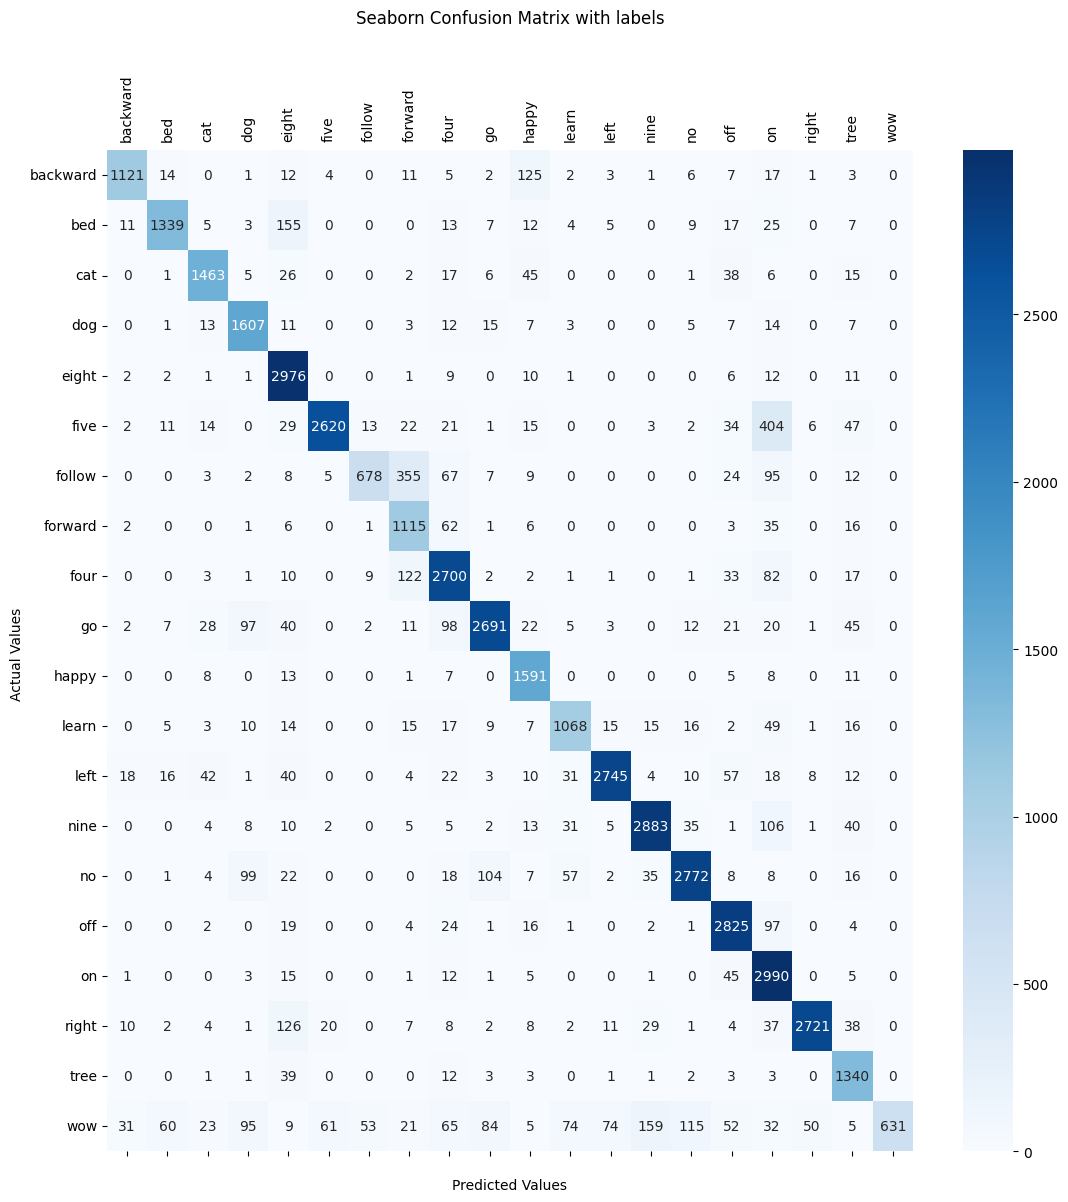

In [92]:

plt.figure(figsize=(13, 13))

ax = sns.heatmap(conf_matrix_train, annot=True, cmap='Blues', fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(train_dataset.classes)
ax.yaxis.set_ticklabels(train_dataset.classes)


plt.tick_params(axis='x', labeltop=True, labelbottom=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

## Display the visualization of the Confusion Matrix.
plt.savefig("train_conf_matrix.png", dpi=300)
plt.show()

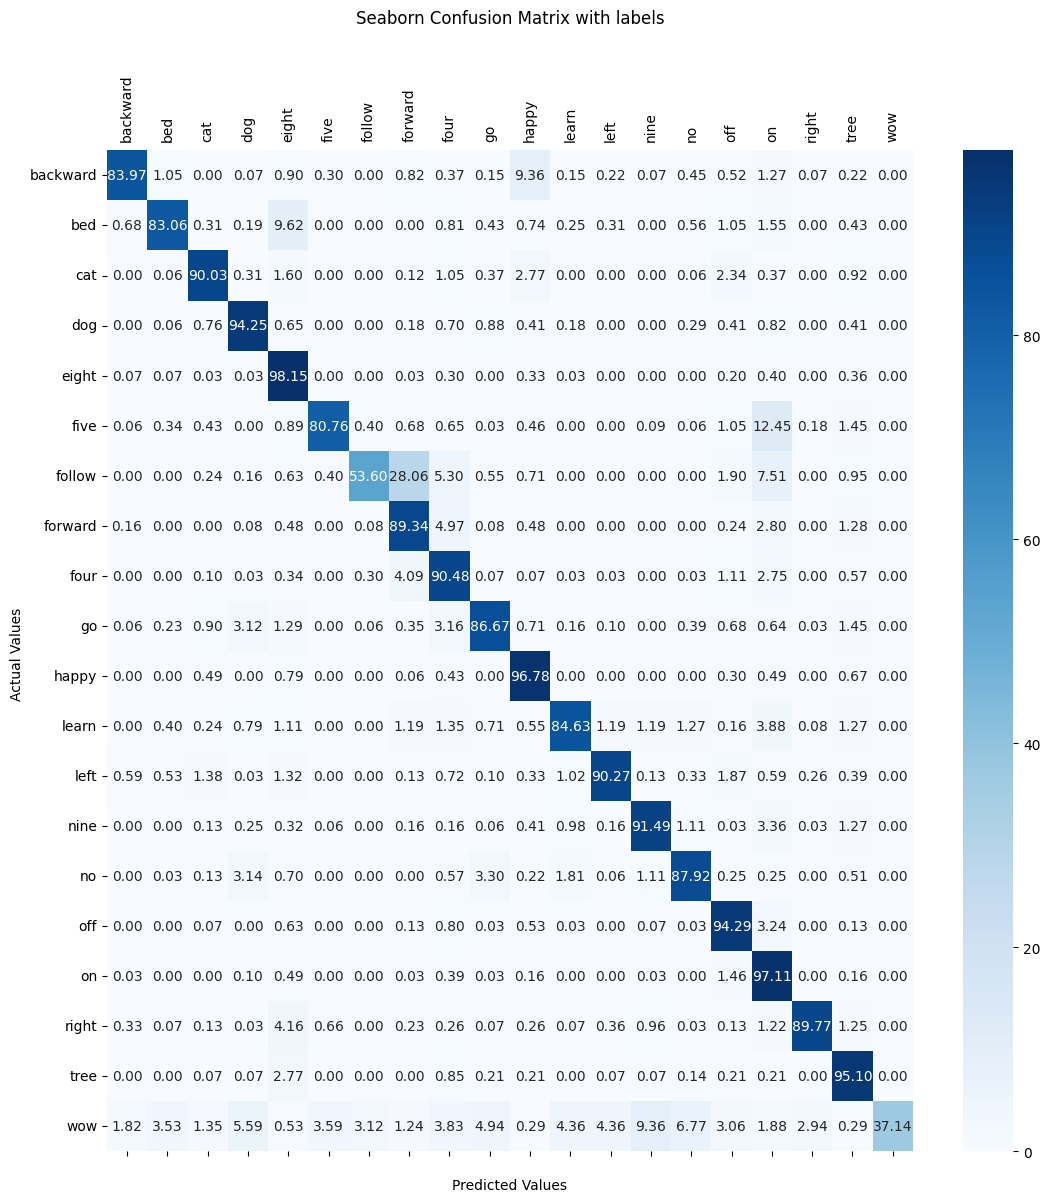

In [94]:

plt.figure(figsize=(13, 13))

ax = sns.heatmap(conf_matrix_train_percent, annot=True, cmap='Blues', fmt='.2f')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(train_dataset.classes)
ax.yaxis.set_ticklabels(train_dataset.classes)


plt.tick_params(axis='x', labeltop=True, labelbottom=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

## Display the visualization of the Confusion Matrix.
plt.savefig("train_conf_matrix_percent.png", dpi=300)
plt.show()

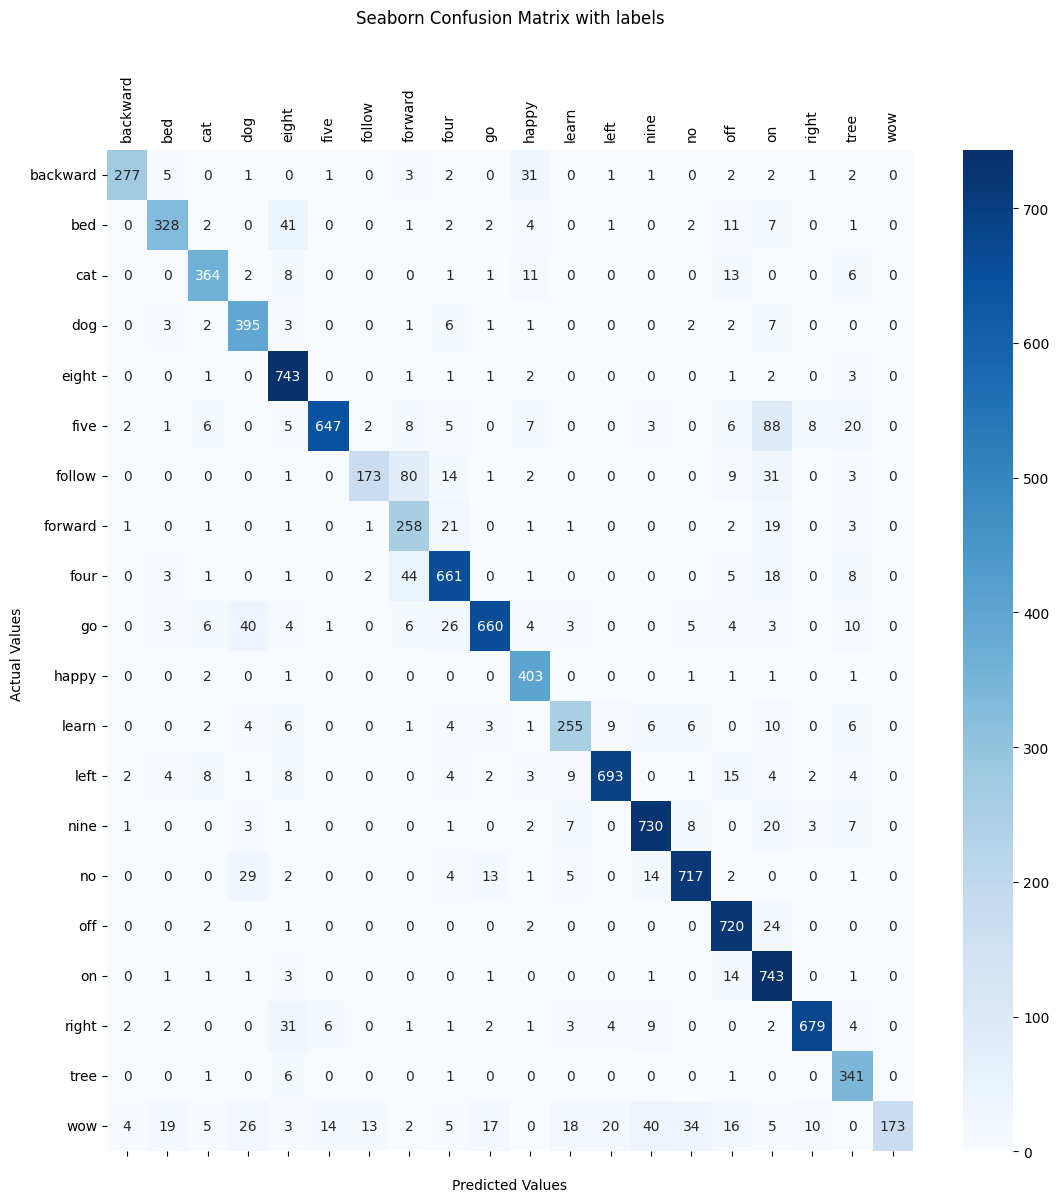

In [93]:

plt.figure(figsize=(13, 13))

ax = sns.heatmap(conf_matrix_valid, annot=True, cmap='Blues', fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(train_dataset.classes)
ax.yaxis.set_ticklabels(train_dataset.classes)


plt.tick_params(axis='x', labeltop=True, labelbottom=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

## Display the visualization of the Confusion Matrix.
plt.savefig("valid_conf_matrix.png", dpi=300)
plt.show()

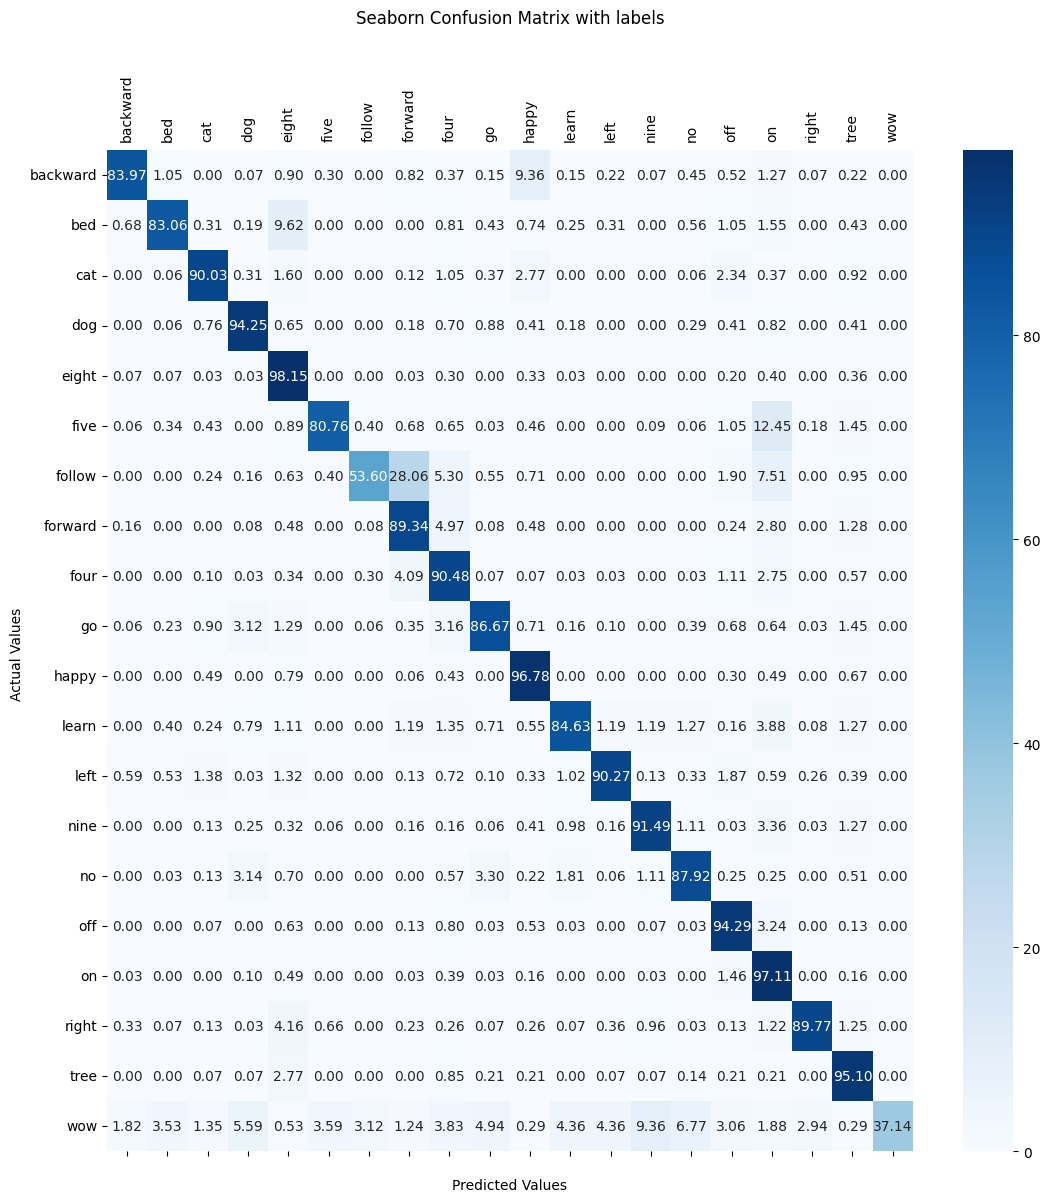

In [95]:

plt.figure(figsize=(13, 13))

ax = sns.heatmap(conf_matrix_valid_percent, annot=True, cmap='Blues', fmt='.2f')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(train_dataset.classes)
ax.yaxis.set_ticklabels(train_dataset.classes)


plt.tick_params(axis='x', labeltop=True, labelbottom=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

## Display the visualization of the Confusion Matrix.
plt.savefig("valid_conf_matrix_percent.png", dpi=300)
plt.show()

## Experiment 1

In [87]:
experiment_settings = {
    'experiment_name': 'base_01',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 32,
        'in_channels': 1,
        'ds_cnn_number': 6,
        'ds_cnn_size': 64,
        'is_classifier': True,
        'classes_number': 20
    },
    'batch_size': 32,
    'n_epoch': 40,
    'loss': 'CrossEntropy',
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.now()),
}

In [88]:
do_experiment(experiment_settings)

<class 'torch.device'> cuda:0
Start experiment base_01 -- 2023-10-09 15:25:00.423148
Model total params: 32404
Model train params: 32404


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

## Experiment 2

In [41]:
experiment_settings = {
    'experiment_name': 'base_02',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 16,
        'in_channels': 1,
        'ds_cnn_number': 3,
        'ds_cnn_size': 64,
    },
    'batch_size': 32,
    'n_epoch': 20,
    'loss': 'CrossEntropy',
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.now()),
}

In [24]:
do_experiment(experiment_settings)

<class 'torch.device'> cuda:0
Start experiment base_02 -- 2023-10-09 11:26:11.373464


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x128 and 64x20)

## Experiment 3

In [ ]:
experiment_settings = {
    'experiment_name': 'base_03',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 64,
        'in_channels': 1,
        'ds_cnn_number': 3,
        'ds_cnn_size': 64,
    },
    'batch_size': 32,
    'n_epoch': 20,
    'loss': 'CrossEntropy',
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.now()),
}

In [ ]:
do_experiment(experiment_settings)

# Experiment 4

In [ ]:
experiment_settings = {
    'experiment_name': 'base_04',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 32,
        'in_channels': 1,
        'ds_cnn_number': 5,
        'ds_cnn_size': 64,
    },
    'batch_size': 32,
    'n_epoch': 20,
    'loss': 'CrossEntropy',
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.now()),
}

In [ ]:
do_experiment(experiment_settings)

## Experiment 5

In [ ]:
experiment_settings = {
    'experiment_name': 'base_05',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 32,
        'in_channels': 1,
        'ds_cnn_number': 7,
        'ds_cnn_size': 64,
    },
    'batch_size': 32,
    'n_epoch': 20,
    'loss': 'CrossEntropy',
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.now()),
}

In [ ]:
do_experiment(experiment_settings)

## Experiment 6

In [ ]:
experiment_settings = {
    'experiment_name': 'base_06',
    'experiments_folder': './experiments/',
    'model': {
        'name': 'DSCNN',
        'n_mels': 32,
        'in_channels': 1,
        'ds_cnn_number': 5,
        'ds_cnn_size': 128,
    },
    'batch_size': 32,
    'n_epoch': 20,
    'loss': 'CrossEntropy',
    'learning_rate': 1e-4,
    'optimizer': 'Adam',
    'time_start': str(datetime.now()),
}

In [ ]:
do_experiment(experiment_settings)

## Another garbage

In [86]:
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in iter(dl_train):
        images = batch['input']
        images = torch.unsqueeze(images, 1)

        labels = batch['target']

        net_out = model(images.to(device))

        result = torch.argmax(net_out, axis=1)
        result = result.to('cpu')

        all_labels += labels.tolist()
        all_preds += result.tolist()
        

In [87]:
print(f'len labels: {len(all_labels)}')
print(f'len preds: {len(all_preds)}')

len labels: 45620
len preds: 45620


In [96]:
# Calculate the Pearson correlation matrix
# rowvar=False means that each column represents a variable, and each row is an observation.

conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix_percent = np.round(conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100, 2)

print("Confusion matrix:")
print(conf_matrix)

Confusion matrix:
[[  56    0    0    0  140   89    0    0   25    6   31    0  372   52
     8   55   20  479    2    0]
 [   0    0    1    0  402  165    0    0   71   49    3    0  211  101
    36  317  139  116    1    0]
 [   1    0   26    0  334  257    0    0   27   55   54    0  417   72
    26  233   26   92    5    0]
 [   0    0    0    0   73  346    0    0   69  443    3    0   31  229
   206  123  147   35    0    0]
 [   3    0    1    0 2425   59    0    0   38   74   16    0   82   44
    30  190   48   19    3    0]
 [   0    0    0    0   48 1970    0    0  183   49    3    0   56  386
    34  119  248  146    2    0]
 [   0    0    0    0   47  235    0    0  475  131    5    0   16   52
    16  113  154   19    2    0]
 [   0    0    0    0   51  205    0    0  680   29    1    0   48   52
     5   74   71   31    1    0]
 [   0    0    0    0   70  364    0    0 1760  145    9    0   26  137
    31  260  142   37    3    0]
 [   0    0    0    0  151  115    0 

In [81]:
train_dataset.classes

['backward',
 'bed',
 'cat',
 'dog',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'learn',
 'left',
 'nine',
 'no',
 'off',
 'on',
 'right',
 'tree',
 'wow']

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(13, 13))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(train_dataset.classes)
ax.yaxis.set_ticklabels(train_dataset.classes)


plt.tick_params(axis='x', labeltop=True, labelbottom=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
plt.figure(figsize=(13, 13))

ax = sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.1f')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(train_dataset.classes)
ax.yaxis.set_ticklabels(train_dataset.classes)


plt.tick_params(axis='x', labeltop=True, labelbottom=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

## Display the visualization of the Confusion Matrix.
plt.show()

# Handy Tools

In [36]:
# Number of model parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Model parameteres number: {pytorch_total_params}')

Model parameteres number: 17236


In [ ]:
# setup device
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)

print(type(device), device)

## Clasterization metric

In [51]:
import numpy as np
import torch
from collections import defaultdict

def clustering_metric_fc(features, labels):
    unique_labels = torch.unique(labels)
    cluster_centers = torch.stack([features[labels == l].mean(dim=0) for l in unique_labels])
    overall_center = features.mean(dim=0)
    intra_class_var = torch.sum(torch.tensor([((features[labels == l] - cluster_centers[i])**2).sum() for i, l in enumerate(unique_labels)]))
    inter_class_var = torch.sum(torch.tensor([((cluster_centers[i] - overall_center)**2).sum() * (labels == l).sum() for i, l in enumerate(unique_labels)]))
    ratio = intra_class_var / inter_class_var

    return ratio


def clustering_metric_hv_one(x1, x2, y1, y2):
    num = torch.norm((x1 - y1) - (x2 - y2))
    den = torch.norm(x1 - y1) + torch.norm(x2 - y2)
    variation = num / den
    return variation

def random_four_elements(groups):
    labels = list(groups.keys())

    while True:

        label = torch.randint(high=len(labels), size=(1,))
        same_label_features = groups[labels[label]]
        if len(same_label_features) < 2:
            continue

        indices = torch.randperm(len(same_label_features))[:2]
        x1, x2 = same_label_features[indices]

        diff_label = torch.randint(high=len(labels), size=(1,))
        while diff_label == label:
            diff_label = torch.randint(high=len(labels), size=(1,))

        diff_label_features = groups[labels[diff_label]]
        if len(diff_label_features) < 2:
            continue

        indices = torch.randperm(len(diff_label_features))[:2]
        y1, y2 = diff_label_features[indices]

        yield x1, x2, y1, y2

def clustering_metric_hv(features, labels, n=100):
    groups = defaultdict(list)
    for feature, label in zip(features, labels):
        groups[label.item()].append(feature)

    unique_labels = torch.unique(labels)
    valid_groups = 0

    for l in unique_labels:
        groups[l.item()] = torch.stack(groups[l.item()])

        if groups[l.item()].shape[0] > 2:
            valid_groups += 1
    
    if valid_groups < 2:
        return 0, 0


    variation = 0
    max_var = 0
    for i in range(n):
        x1, x2, y1, y2 = next(random_four_elements(groups))
        var = clustering_metric_hv_one(x1, x2, y1, y2)

        variation += var

        if var > max_var:
            max_var = var

    variation /= n

    return variation, max_var
